# Setup Environment

## Setup Miniconda

In [ ]:
%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

## Check Install Directories

In [ ]:
!which conda # should return /usr/local/bin/conda

In [ ]:
!conda --version # should return 4.5.4

In [ ]:
!which python # still returns /usr/local/bin/python

In [ ]:
!python --version # now returns Python 3.6.5 :: Anaconda, Inc.

## Setup Environment using Miniconda

In [ ]:
%%bash
conda install --channel defaults conda python=3.6 --yes
conda update --channel defaults --all --yes

In [ ]:
!conda --version # now returns 4.8.3

In [ ]:
!python --version # now returns Python 3.6.10 :: Anaconda, Inc.

In [ ]:
import sys
sys.path

In [ ]:
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.6/site-packages"))

## Install Conda Packages

In [ ]:
!conda install --channel conda-forge featuretools --yes

In [ ]:
!conda install cudatoolkit=10.1 -y
!conda install pytorch -c pytorch -y
!conda install libsndfile=1.0.28 -c conda-forge -y
!conda install ipykernel -y

In [ ]:
!pip3 install absl-py librosa soundfile matplotlib scipy scikit-learn numba jiwer unidecode deepspeech==0.8.2

# Download and Check Dataset

## Download Dataset

In [ ]:
gdrive = True
if gdrive:
    # Download from Google Drive, much faster than from source
    # NOTE: Still getting this too work...
    !EEG_DATA_ID="1GT_hZTCx0ihdjcPvQFgYltmNZU5iIxvj" && \
    wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=${EEG_DATA_ID}" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=${EEG_DATA_ID}" -O emg_data.tar.gz && rm -rf /tmp/cookies.txt
else:
    # Download from source, slower but should be 100% reliable
    !wget -O emg_data.tar.gz https://zenodo.org/record/4064409/files/emg_data.tar.gz?download=1

## Phoneme Dataset

In [ ]:
!wget -O text_alignments.tar.gz https://github.com/dgaddy/silent_speech_alignments/raw/main/text_alignments.tar.gz
!tar -xvf text_alignments.tar.gz

## Check EEG Dataset Size (Should be ~6.3GB)

In [ ]:
!du -sh emg_data

# Clone GDaddy/silent_speech Repository

In [ ]:
!git clone https://github.com/dgaddy/silent_speech/

# Closed Vocab Dataset
This dataset is split into two modes:
1. Voiced speech
2. Silent speech

In [5]:
# Required
!pip install praat-textgrids

# Use this to change dir (If not already in silent_speech repo dir)
!pwd
switch = False
if switch:
    %cd silent_speech

/mnt/c/Users/win8t/OneDrive/Desktop/projects/silent_speech_analysis


## Analyse Entire Dataset Statistics

### Dataset Statistics
According to the [Digital Voicing of Silent Speech](https://arxiv.org/pdf/2010.02960.pdf)
paper, the closed vocabulary dataset should have the following chracteristics:
- Parallel silent / vocalised Speech (Es, Ev, Av)
  - 26 minutes silent / 30 minutes vocalised
  - Single session (data was only recorded once)
  - 500 utterances (500 different recordings)
  - Average of 4 words per utterance
  - 67 words in vocabulary (67 unique words were uttered in the entire dataset)
  
From the cells below, we can see the dataset matches the reported
statistics within the paper, aside from the vocabulary.

However, this is most likely due to how the vocabulary words
are calculated by the authors. Hopefully this is easy to resolve.

#### Extract Dataset Information

In [32]:
#%cd silent_speech_analysis
!pwd

import os, json, glob

# Silent and voiced directories
emg_data_dir = "emg_data/"
silent_dir = os.path.join(os.getcwd(), "silent_speech/", emg_data_dir, "closed_vocab/silent/5-19_silent")
voiced_dir = os.path.join(os.getcwd(), "silent_speech/", emg_data_dir, "closed_vocab/voiced/5-19")

# Calc unique words within a data directory
def vocab_info(data_dir):
    path = data_dir
    jsons = list(filter(lambda x: x.endswith(".json"), os.listdir(path)))
    infos = []
    for fname in jsons:
        cur_fname = os.path.join(data_dir, fname)
        with open(cur_fname) as f:
            info = json.loads(f.read())
            infos.append(info)
    return infos

# Get silent mode vocab
silent_info = vocab_info(silent_dir)
voiced_info = vocab_info(voiced_dir)

/mnt/c/Users/win8t/OneDrive/Desktop/projects/silent_speech_analysis


#### Calculate Vocabulary Size

In [ ]:
import re

reduce_year_vocab_size = False

#silent_vocab = set()
silent_vocab = list()
for info in silent_info:
    words = re.split(":| ", info["text"])
    for w in words:
        if len(w) == 4 and w.isnumeric() and reduce_year_vocab_size:
            w1 = w[0:2]
            w2 = w[2:4]
            silent_vocab.append(w1)
            silent_vocab.append(w2)
            #silent_vocab.add(w1)
            #silent_vocab.add(w2)
        else:
            # silent_vocab.add(w)
            silent_vocab.append(w)
silent_vocab.remove("")

voiced_vocab = set()
for info in voiced_info:
    words = re.split(":| ", info["text"])
    for w in words:
        if len(w) == 4 and w.isnumeric() and reduce_year_vocab_size:
            w1 = w[0:2]
            w2 = w[2:4]
            voiced_vocab.add(w1)
            voiced_vocab.add(w2)
        else:
            voiced_vocab.add(w)
voiced_vocab.remove("")

print('Silent Vocab Size, Voiced Vocab Size:', len(silent_vocab), len(voiced_vocab))

silent_vocab

I'm not sure how the authors calculated the 67 words in their vocab, as there are actually 113 unique words within the dataset. The way they calculate their vocabulary must be different to how I have. The method I have used is to sum 12 hour suffixes (AM/PM) with 1 digit number occurances, two digit number occurances, 7 days a week and 12 months a year.

The authors must be reducing the vocabulary down by grouping some of the numbers which are uttered, further investigation here is required.

#### Utterance Calculations

In [34]:
raw_silent_utters = [info["text"] for info in silent_info]
raw_silent_utters = list(filter(lambda x: x != "", raw_silent_utters))

raw_voiced_utters = [info["text"] for info in voiced_info]
raw_voiced_utters = list(filter(lambda x: x != "", raw_voiced_utters))

silent_utterances = set(raw_silent_utters)
voiced_utterances = set(raw_voiced_utters)

silent_utterance_indices = set([info["sentence_index"] for info in silent_info])
voiced_utterance_indices = set([info["sentence_index"] for info in voiced_info])

def get_utter_word_count(utterance):
    words = re.split(":| ", utterance)
    cnt = 0
    for w in words:
        if len(w) == 4 and w.isnumeric():
            cnt += 2
        else:
            cnt += 1
    return cnt

avg_silent_utter_words = [get_utter_word_count(u) for u in raw_silent_utters]
print('Silent utter avg:', set(avg_silent_utter_words), avg_silent_utter_words, sum(avg_silent_utter_words), len(avg_silent_utter_words), sum(avg_silent_utter_words) / len(avg_silent_utter_words))
avg_silent_utter_words = sum(avg_silent_utter_words) / len(avg_silent_utter_words)

avg_voiced_utter_words = [get_utter_word_count(u) for u in raw_voiced_utters]
print('Voiced utter avg:', set(avg_voiced_utter_words), avg_voiced_utter_words, sum(avg_voiced_utter_words), len(avg_voiced_utter_words), sum(avg_voiced_utter_words) / len(avg_voiced_utter_words))
avg_voiced_utter_words = sum(avg_voiced_utter_words) / len(avg_voiced_utter_words)

print('Silent, Voiced utterance counts:', len(silent_utterances), len(voiced_utterances))
print('Index counts (silent, voiced):', len(silent_utterance_indices), len(voiced_utterance_indices))
print('Raw (silent, voiced) utterance counts:', len(raw_silent_utters), len(raw_voiced_utters))
print('Avg words/utterance (silent, voiced) counts:', avg_silent_utter_words, avg_voiced_utter_words)

Silent utter avg: {3, 4} [3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4,

The sentence index (in other words, the indices into the utterances) matches what is reported exactly.
The [Digital Voicing of Silent Speech](https://arxiv.org/pdf/2010.02960.pdf) paper reports
500 utterances, and their are 500 sentences (i.e. utterances) plus an additional recording which
contains no speech.
Presumably this is an initial recording to ensure the recording environment (OpenBCI
EEG recording hardware and software) were working correctly.

#### Audio Calculations

In [35]:
import os

"""
silent_dir
voiced_dir
"""

import librosa
silent_flacs = list(filter(lambda x: x.endswith("clean.flac"), os.listdir(silent_dir)))
voiced_flacs = list(filter(lambda x: x.endswith("clean.flac"), os.listdir(voiced_dir)))

silent_audio_duration = 0 # Seconds
for fname in silent_flacs:
    silent_audio_duration += librosa.get_duration(filename=os.path.join(silent_dir, fname))
    
voiced_audio_duration = 0 # Seconds
for fname in voiced_flacs:
    voiced_audio_duration += librosa.get_duration(filename=os.path.join(voiced_dir, fname))
    
silent_mins = silent_audio_duration / 60.0
audio_mins = voiced_audio_duration / 60.0

print(f'Audio (Silent, Voiced) duration (mins): {silent_mins:.2f}, {audio_mins:.2f}')

Audio (Silent, Voiced) duration (mins): 26.46, 29.53


The silent and voiced audio durations match the Digital Voicing paper, with 26 mins and 30 mins roughly, reported for the silent and voiced modes respectively.

## Parallel Ev, Av Data Analysis

In the EMG dataset, Ev refers to EMG data recorded during the vocalised mode and audio data recorded during the vocalised mode respectively. The data is recorded in parallel, so the emg and audio data are time-aligned.

For context, the electrode placements for this dataset are as follows:

| No   | Location                            |
| ---- | ----------------------------------- |
| 1    | left cheek just above mouth         |
| 2    | left corner of chin                 |
| 3    | below chin below 3cm                |
| 4    | throat 3cm left from Adam's apple   |
| 5    | mid-jaw right                       |
| 6    | right cheek just below mouth        |
| 7    | right cheek 2cm from nose          |
| 8    | back of right cheek                 |
| ref  | below left ear                      |
| bias | below right ear                     |

<center>
<img src="./assets/digital_voicing/digital_voicing_electrode_placements.png"
     alt="digital voicing electrode placements" />
</center>

Order of electrodes does not imply importance, these were just the numberings
of the electrodes within the data.

In [36]:
# Smallest audio file in the closed vocab dataset
# 573 = "Sunday March 10th"
import os
recording_idx = 573
ev_path = os.path.join(voiced_dir,
                       f'./{recording_idx}_emg.npy')
av_path = os.path.join(voiced_dir,
                       f'./{recording_idx}_audio_clean.flac')

### Visualise an Audio Recording

In [37]:
# Create array from audio file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lr

audio, sfreq = lr.load(av_path)
time = np.arange(0, len(audio)) / sfreq

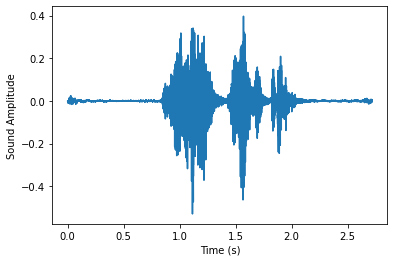

In [38]:
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

### Visualise an EMG Recording

#### Visualisation Methods

In [99]:
"""
Taken from "https://github.com/dgaddy/silent_speech"
I've copied functions here as using them directly
from the library causes headaches with the FLAGS library

Collapse this if you don't care how the functions work.
"""

def load_audio(filename, start=None, end=None, max_frames=None, renormalize_volume=False):
    audio, r = sf.read(filename)
    assert r == 16000

    if len(audio.shape) > 1:
        audio = audio[:,0] # select first channel of stero audio
    if start is not None or end is not None:
        audio = audio[start:end]

    if renormalize_volume:
        audio = normalize_volume(audio)
    mel_spectrogram = False
    if mel_spectrogram:
        mfccs = librosa.feature.melspectrogram(audio, sr=16000, n_mels=128, center=False, n_fft=512, win_length=432, hop_length=160).T
        mfccs = np.log(mfccs+1e-5)
    else:
        mfccs = librosa.feature.mfcc(audio, sr=16000, n_mfcc=26, n_fft=512, win_length=432, hop_length=160, center=False).T
    audio_discrete = librosa.core.mu_compress(audio, mu=255, quantize=True)+128
    if max_frames is not None and mfccs.shape[0] > max_frames:
        mfccs = mfccs[:max_frames,:]
    audio_length = 160*mfccs.shape[0]+(432-160)
    audio_discrete = audio_discrete[:audio_length] # cut off audio to match framed length
    return mfccs.astype(np.float32), audio_discrete

def load_utterance(base_dir, index, limit_length=False, debug=False, text_align_directory=None):
    index = int(index)
    raw_emg = np.load(os.path.join(base_dir, f'{index}_emg.npy'))
    before = os.path.join(base_dir, f'{index-1}_emg.npy')
    after = os.path.join(base_dir, f'{index+1}_emg.npy')
    if os.path.exists(before):
        raw_emg_before = np.load(before)
    else:
        raw_emg_before = np.zeros([0,raw_emg.shape[1]])
    if os.path.exists(after):
        raw_emg_after = np.load(after)
    else:
        raw_emg_after = np.zeros([0,raw_emg.shape[1]])

    x = np.concatenate([raw_emg_before, raw_emg, raw_emg_after], 0)
    x = apply_to_all(notch_harmonics, x, 60, 1000)
    x = apply_to_all(remove_drift, x, 1000)
    x = x[raw_emg_before.shape[0]:x.shape[0]-raw_emg_after.shape[0],:]
    emg_orig = apply_to_all(subsample, x, 800, 1000)
    x = apply_to_all(subsample, x, 600, 1000)
    emg = x
    
    remove_channels = []
    for c in remove_channels:
        emg[:,int(c)] = 0
        emg_orig[:,int(c)] = 0

    emg_features = get_emg_features(emg, debug=True)

    mfccs, audio_discrete = load_audio(os.path.join(base_dir, f'{index}_audio_clean.flac'),
            max_frames=min(emg_features.shape[0], 800 if limit_length else float('inf')))

    if emg_features.shape[0] > mfccs.shape[0]:
        emg_features = emg_features[:mfccs.shape[0],:]
    emg = emg[6:6+6*emg_features.shape[0],:]
    emg_orig = emg_orig[8:8+8*emg_features.shape[0],:]
    assert emg.shape[0] == emg_features.shape[0]*6

    with open(os.path.join(base_dir, f'{index}_info.json')) as f:
        info = json.load(f)

    sess = os.path.basename(base_dir)
    tg_fname = f'{text_align_directory}/{sess}/{sess}_{index}_audio.TextGrid'
    if os.path.exists(tg_fname):
        phonemes = read_phonemes(tg_fname, mfccs.shape[0], phoneme_inventory)
    else:
        phonemes = np.zeros(mfccs.shape[0], dtype=np.int64)+phoneme_inventory.index('sil')

    return mfccs, audio_discrete, emg_features, info['text'], (info['book'],info['sentence_index']), phonemes, emg_orig.astype(np.float32)

In [59]:
# Get inside of `silent_speech` repo
!pwd
switch = False
if switch:
    %cd silent_speech

/mnt/c/Users/win8t/OneDrive/Desktop/projects/silent_speech_analysis/silent_speech


In [ ]:
"""
Utterance format:
mfccs, audio_discrete, emg_features, text, (book, sentence_index),
phonemes, emg_orig
"""
utterance = load_utterance(voiced_dir, 573)
utterance

Text(0.5, 1.0, 'Ev - EMG From Vocalised Speech')

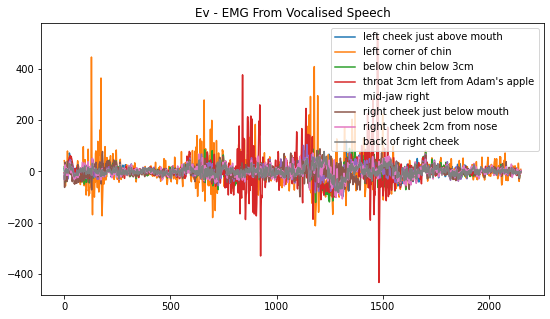

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)

emg_channel_labels = """left cheek just above mouth
left corner of chin
below chin below 3cm
throat 3cm left from Adam's apple
mid-jaw right
right cheek just below mouth
right cheek 2cm from nose
back of right cheek""".split("\n")

raw_emg = utterance[-1]
channels = [ax.plot(raw_emg[:, i], label=emg_channel_labels[i]) for i in range(raw_emg.shape[1])]
ax.legend()

plt.title("Ev - EMG From Vocalised Speech")

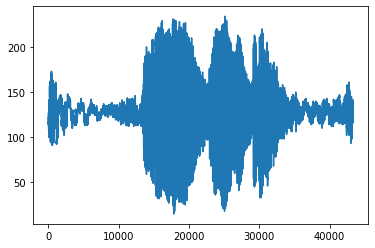

In [103]:
audio_discrete = utterance[1]
audio_discrete.shape
plt.plot(audio_discrete)